<a href="https://colab.research.google.com/github/poornachandra24/custom_cnn/blob/main/custom_zfnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset.zip','r')
zip_ref.extractall('/content/drive/MyDrive')
zip_ref.close()'''


In [4]:
image_dir = Path('/content/drive/MyDrive/Dataset')

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [6]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [7]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths,labels], axis=1)

In [8]:
labels.value_counts()

Healthy      2981
Corrosion    2807
Cracks       2537
Name: Label, dtype: int64

In [9]:
X, Y = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [10]:
import tensorflow as tf

# Define ImageDataGenerator for training data with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',

    validation_split=0.2  # This indicates the split ratio for validation
)

# Define ImageDataGenerator for testing data with the same augmentation
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',

)


In [11]:
train_images = train_generator.flow_from_dataframe(dataframe = X, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=True,
                                                   seed=42, subset='training')

val_images = train_generator.flow_from_dataframe(dataframe = X, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=True,
                                                   seed=42, subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe = Y, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=False)

Found 4662 validated image filenames belonging to 3 classes.
Found 1165 validated image filenames belonging to 3 classes.
Found 2498 validated image filenames belonging to 3 classes.


In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint (filepath= "./best_model.h5",monitor="val_acc",verbose=1,save_best_only= True)
es = EarlyStopping (monitor= "val_acc",min_delta= 0.01,patience= 5,verbose= 1)
cb = [mc, es]

In [15]:
# Define the Custom-CNN architecture
model = models.Sequential()

# Conv1
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Conv2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv4
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv5
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten
model.add(layers.Flatten())

# FC1
model.add(layers.Dense(128, activation='relu'))

# FC2
model.add(layers.Dense(128, activation='relu'))

# FC3
model.add(layers.Dense(64, activation='relu'))

# FC4
model.add(layers.Dense(3, activation='softmax'))  # 3 classes

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 64)      

In [16]:

model.compile('adam',
    loss='categorical_crossentropy',
    metrics=['acc'])



In [17]:
hist = model.fit(train_images, epochs=50, validation_data=val_images ,batch_size= 32, callbacks=[cb] )

Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.2430 - acc: 0.9224 
Epoch 1: val_acc improved from -inf to 0.92103, saving model to ./best_model.h5
146/146 [==============================] - 4722s 32s/step - loss: 0.2430 - acc: 0.9224 - val_loss: 0.2546 - val_acc: 0.9210
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.1319 - acc: 0.9597
Epoch 2: val_acc improved from 0.92103 to 0.96481, saving model to ./best_model.h5
146/146 [==============================] - 85s 579ms/step - loss: 0.1319 - acc: 0.9597 - val_loss: 0.1124 - val_acc: 0.9648
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.1175 - acc: 0.9640
Epoch 3: val_acc improved from 0.96481 to 0.97253, saving model to ./best_model.h5
146/146 [==============================] - 85s 580ms/step - loss: 0.1175 - acc: 0.9640 - val_loss: 0.0754 - val_acc: 0.9725
Epoch 4/50
146/146 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.9732
Epoch 4: val_acc 

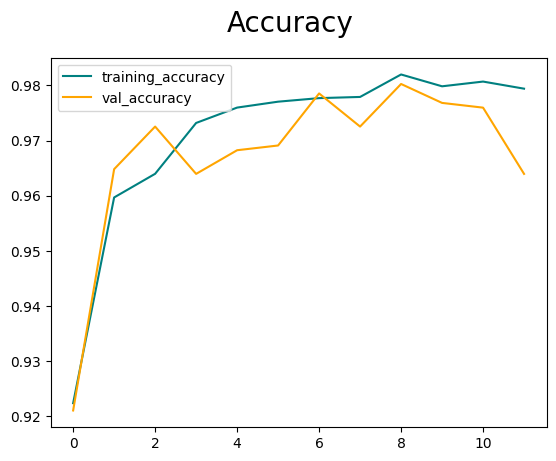

In [18]:
#plotting accuracy
fig = plt.figure()
plt.plot(hist.history['acc'], color='teal', label='training_accuracy')
plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

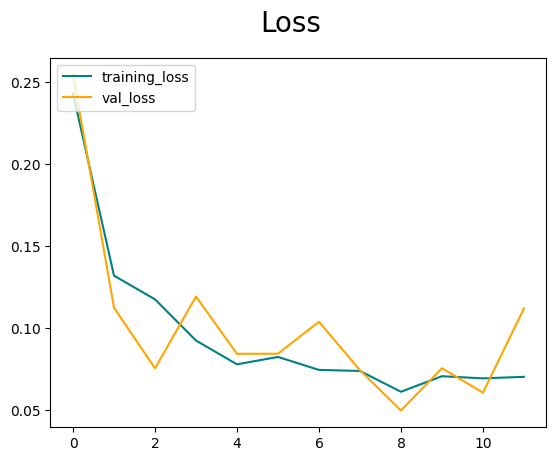

In [19]:
#plotting loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='training_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
results = model.evaluate(test_images, verbose=1)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

79/79 [==============================] - 1851s 24s/step - loss: 0.0989 - acc: 0.9688
Test Accuracy: 96.88%


In [22]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
predictions = np.argmax(model.predict(test_images),axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices)

79/79 [==============================] - 34s 431ms/step


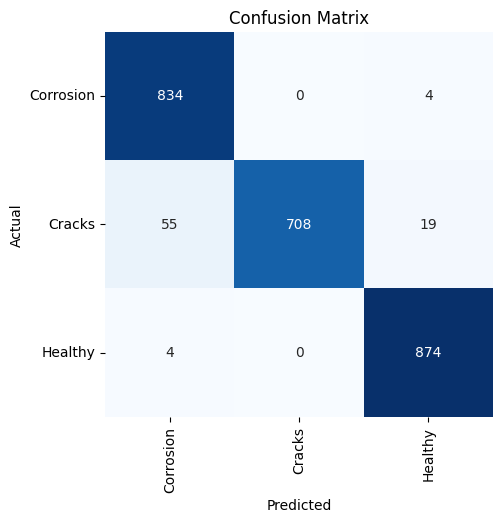

In [23]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar = False)
plt.xticks(ticks=np.arange(3)+0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(3)+0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
print('Classification Report:\n----------------------\n', clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Corrosion       0.93      1.00      0.96       838
      Cracks       1.00      0.91      0.95       782
     Healthy       0.97      1.00      0.98       878

    accuracy                           0.97      2498
   macro avg       0.97      0.97      0.97      2498
weighted avg       0.97      0.97      0.97      2498

